 ### 1. Preprocess Data (Clean & Encode)
>We'll handle:

>>>Convert TotalCharges to float

>>>Label encode categorical variables

>>>Let's start by writing the preprocessing function. 


>>>>>>Preprocessing complete!
All categorical variables have been label-encoded, and TotalCharges is converted to numeric.

In [2]:
# Load the uploaded training and test datasets
import pandas as pd

# File paths
train_path = "telco_train.csv.csv"
test_path = "telco_test.csv.csv"

# Load CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show basic info
train_info = train_df.info()
test_info = test_df.info()

# Show first few rows for a quick check
train_head = train_df.head()
test_head = test_df.head()

train_df.shape, test_df.shape, train_head, test_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


((5634, 21),
 (1409, 20),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  4950-BDEUX    Male              0      No         No      35           No   
 1  7993-NQLJE    Male              0     Yes        Yes      15          Yes   
 2  7321-ZNSLA    Male              0     Yes        Yes      13           No   
 3  4922-CVPDX  Female              0     Yes         No      26          Yes   
 4  2903-YYTBW    Male              0     Yes        Yes       1          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...              Yes   
 1                No     Fiber optic            Yes  ...               No   
 2  No phone service             DSL            Yes  ...               No   
 3                No             DSL             No  ...              Yes   
 4                No             DSL             No  ...               No   
 
   TechSupport Streami

###  2. Train a Model (XGBoost)


>>> Train an XGBoost classifier

>>> Optimize for AUC-ROC (per hackathon rubric)

>>> Evaluate it

In [3]:
from sklearn.preprocessing import LabelEncoder

def preprocess(df, is_train=True):
    df = df.copy()
    
    # Convert TotalCharges to numeric, coerce errors and fill NAs
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    
    # Drop customerID
    if 'customerID' in df.columns:
        df.drop(columns='customerID', inplace=True)
    
    # Encode all object (categorical) columns
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    return df

# Apply preprocessing
train_processed = preprocess(train_df)
test_processed = preprocess(test_df, is_train=False)

train_processed.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churned
0,1,0,0,0,35,0,1,0,0,0,2,0,2,2,0,0,2,49.20,1701.65,0
1,1,0,1,1,15,1,0,1,2,0,0,0,0,0,0,0,3,75.10,1151.55,0
2,1,0,1,1,13,0,1,0,2,2,0,2,0,0,2,0,3,40.55,590.35,0
3,0,0,1,0,26,1,0,0,0,2,2,0,2,2,2,1,1,73.50,1905.70,0
4,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,2,44.55,44.55,0


In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Split features and labels
X = train_processed.drop('churned', axis=1)
y = train_processed['churned']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict
val_preds = model.predict_proba(X_val)[:, 1]

# Evaluate AUC-ROC
auc = roc_auc_score(y_val, val_preds)
print(f"AUC-ROC on validation set: {auc:.4f}")


AUC-ROC on validation set: 0.8122


C:\Users\shubh\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [18:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


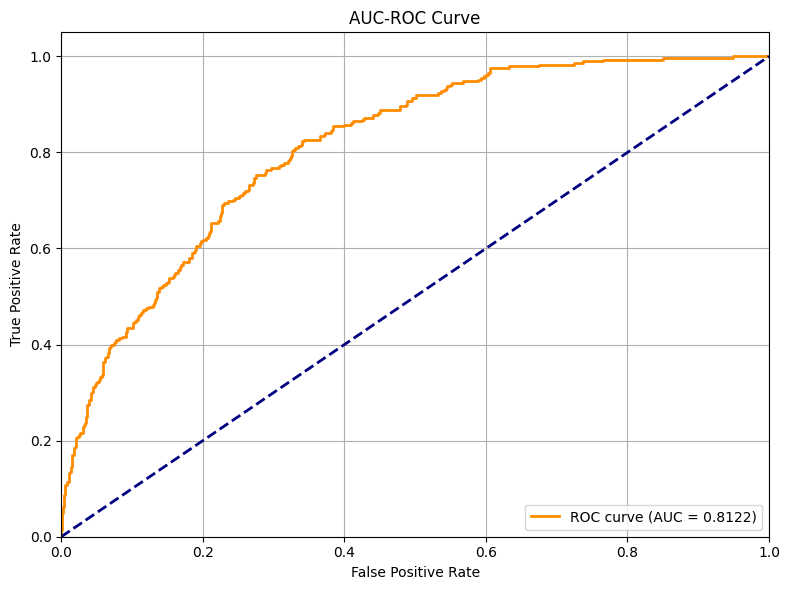

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get FPR, TPR
fpr, tpr, thresholds = roc_curve(y_val, val_preds)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Predict Churn Probabilities on Test Set

In [9]:
# Predict churn probabilities on test data
test_probs = model.predict_proba(test_processed)[:, 1]

# Add prediction column to test set
test_results = test_df.copy()
test_results['churn_probability'] = test_probs

# Show top 5 risky users
test_results[['customerID', 'churn_probability']].sort_values(by='churn_probability', ascending=False).head(5)


,customerID,churn_probability
1175,6861-XWTWQ,0.989918
872,5167-ZFFMM,0.986305
1188,0655-RBDUG,0.986114
947,3006-XIMLN,0.983178
788,1143-NMNQJ,0.982858


###  Plot Churn Probability Distribution
This step helps visualize how the churn risk is spread across your user base.

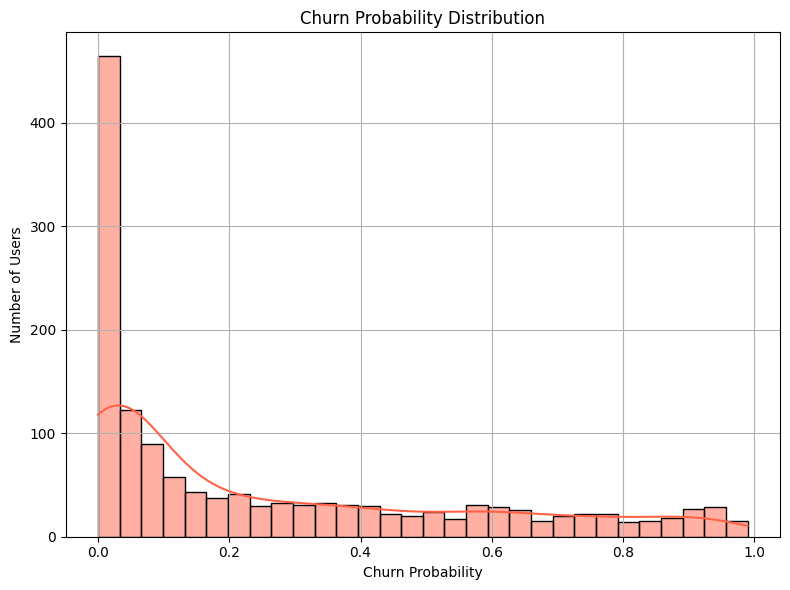

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot churn probability distribution
plt.figure(figsize=(8, 6))
sns.histplot(test_results['churn_probability'], bins=30, kde=True, color='tomato')
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Number of Users")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Plot Churn vs Retained Pie Chart
We'll assume:

Users with churn probability > 0.5 are predicted to churn.

The rest are retained.

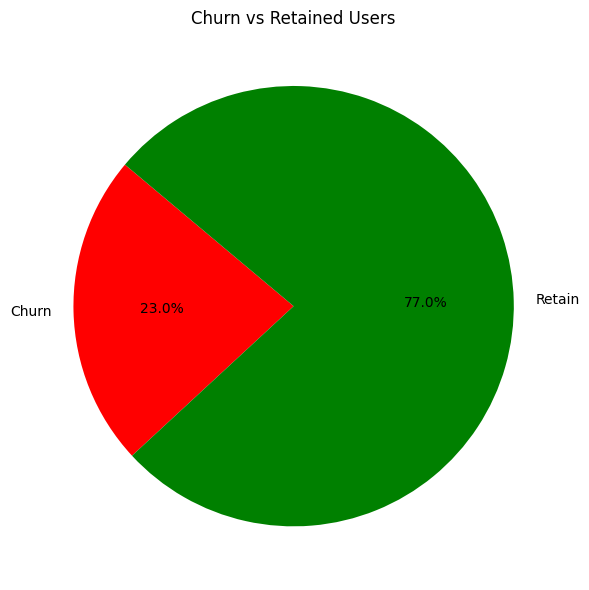

In [11]:
import matplotlib.pyplot as plt

# Threshold for churn
threshold = 0.5
churned = (test_results['churn_probability'] > threshold).sum()
retained = len(test_results) - churned

# Pie chart
labels = ['Churn', 'Retain']
sizes = [churned, retained]
colors = ['red', 'green']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Churn vs Retained Users")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()


### Display Top 10 At-Risk Users

In [12]:
# Sort by churn probability
top_10_risk = test_results[['customerID', 'churn_probability']].sort_values(by='churn_probability', ascending=False).head(10)

# Display top 10
print("Top 10 At-Risk Users:")
print(top_10_risk.to_string(index=False))


Top 10 At-Risk Users:
customerID  churn_probability
6861-XWTWQ           0.989918
5167-ZFFMM           0.986305
0655-RBDUG           0.986114
3006-XIMLN           0.983178
1143-NMNQJ           0.982858
4445-ZJNMU           0.980702
8375-DKEBR           0.979401
9248-OJYKK           0.976382
6137-NICCO           0.968214
4927-WWOOZ           0.968133
